<a href="https://colab.research.google.com/github/sereliezer/sereliezer.github.io/blob/master/content/teaching/deeplearning-ufc-2025/ipynb/aula1_rbf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplo Prático: Rede Rasa vs. Aprendizado Profundo com RBFs

Este notebook demonstra a diferença fundamental entre uma abordagem de aprendizado "rasa" (com funções de base fixas) e uma abordagem que se assemelha ao aprendizado profundo (onde as próprias funções de base são aprendidas).

Usaremos Redes de Funções de Base Radial (RBFs) para aproximar um polinômio desconhecido, ilustrando os conceitos discutidos na Aula 1.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os

# Configurações de estilo para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14})

## Passo 1: Gerar os Dados

Primeiro, criamos uma "função verdadeira" desconhecida, que será um polinômio de grau aleatório (entre 3 e 10). Em seguida, amostramos 100 pontos a partir desta função e adicionamos um pouco de ruído para simular dados do mundo real.

Grau do polinômio verdadeiro: 3


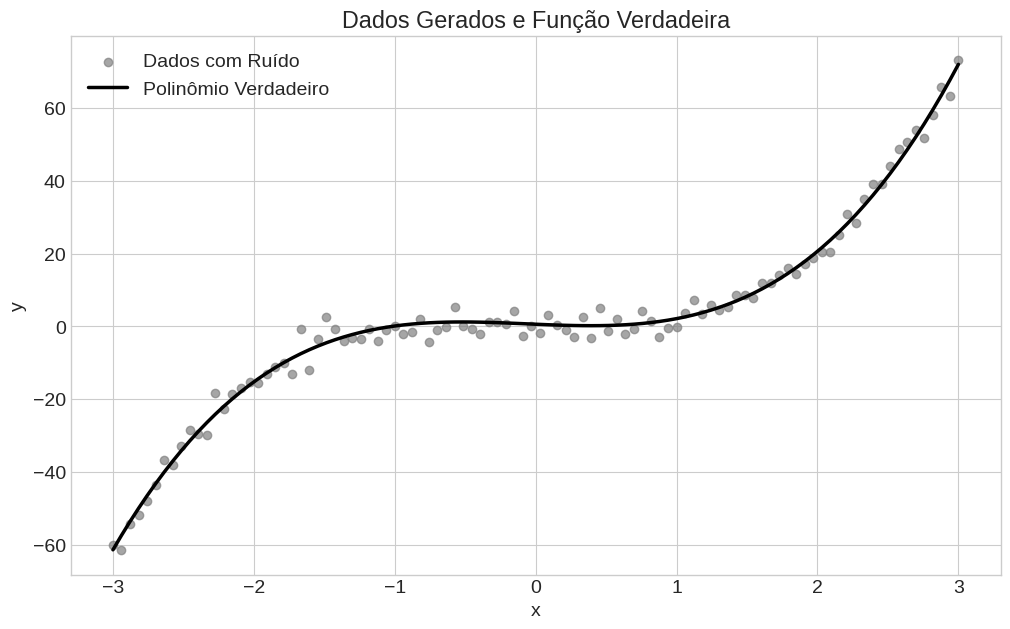

In [ ]:
# Definir a semente para reprodutibilidade
#np.random.seed(477)
#torch.manual_seed(423)

# Gerar um polinômio aleatório
degree = np.random.randint(3, 7)
coeffs = np.random.randn(degree + 1)
true_polynomial = np.poly1d(coeffs)

# Gerar 100 pontos de dados com ruído
N = 100
x_data = np.linspace(-3, 3, N)
y_true = true_polynomial(x_data)
noise = np.random.randn(N) * 2.5 # Nível de ruído
y_data = y_true + noise

print(f"Grau do polinômio verdadeiro: {degree}")

# Plotar os dados gerados
plt.figure(figsize=(12, 7))
plt.scatter(x_data, y_data, label='Dados com Ruído', alpha=0.7, color='gray')
plt.plot(x_data, y_true, 'k-', linewidth=2.5, label='Polinômio Verdadeiro')
plt.title('Dados Gerados e Função Verdadeira')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.savefig('dados_gerados.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Passo 2: Modelo 1 - Rede Rasa (Bases Fixas)

Nesta abordagem, escolhemos os parâmetros das nossas funções de base (os centros `c` das RBFs) de forma aleatória e os mantemos **fixos**. O único aprendizado ocorre nos pesos da camada de saída `w`, que podem ser encontrados analiticamente através da solução de mínimos quadrados (usando a pseudo-inversa).

In [ ]:
# Número de neurônios RBF (funções de base)
M = 3

# Escolher M centros aleatoriamente a partir dos dados e mantê-los fixos
fixed_centers = np.random.choice(x_data, size=M, replace=False)
fixed_sigma = x_data.std() * 0.8 # Heurística para a largura

print(f"Centros Fixos: {np.round(fixed_centers, 2)}")
print(f"Largura (Sigma) Fixa: {np.round(fixed_sigma, 2)}")

# Função para calcular a matriz de design (features)
def rbf_features(x, centers, sigma):
    # Adiciona uma coluna de 1s para o viés (w0)
    phi = np.ones((len(x), len(centers) + 1))
    for i, center in enumerate(centers):
        phi[:, i+1] = np.exp(-(x - center)**2 / (2 * sigma**2))
    return phi

# Calcular a matriz Phi para os dados de treinamento
Phi = rbf_features(x_data, fixed_centers, fixed_sigma)

# Encontrar os pesos ótimos w usando a solução de mínimos quadrados
# w = (Phi^T Phi)^-1 Phi^T y
w_optimal_shallow = np.linalg.pinv(Phi).dot(y_data)

# Fazer a predição com o modelo treinado
y_pred_shallow = Phi.dot(w_optimal_shallow)

Centros Fixos: [-2.45 -0.82 -1.79]
Largura (Sigma) Fixa: 1.4


## Passo 3: Modelo 2 - Abordagem "Profunda" (Bases Aprendidas)

Agora, tratamos **todos** os parâmetros (pesos `w`, centros `c` e larguras `σ`) como aprendíveis. Usamos o PyTorch e a descida de gradiente para otimizar todos eles simultaneamente, minimizando o Erro Quadrático Médio (MSE).

Isso se assemelha mais ao Deep Learning, onde a rede aprende as próprias features (as funções de base) que são mais úteis para resolver o problema.

In [ ]:
# Converter dados para tensores do PyTorch
x_tensor = torch.tensor(x_data, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)

# Definir o modelo RBF como uma classe do PyTorch
class RBFNet(nn.Module):
    def __init__(self, num_rbf):
        super(RBFNet, self).__init__()
        # Inicializa os centros aleatoriamente
        self.centers = nn.Parameter(torch.randn(num_rbf, 1))
        # Usa log_sigmas para garantir que sigmas sejam sempre positivos
        self.log_sigmas = nn.Parameter(torch.randn(num_rbf))
        # Pesos da camada de saída
        self.w = nn.Parameter(torch.randn(num_rbf, 1))
        self.w0 = nn.Parameter(torch.randn(1)) # Viés

    def forward(self, x):
        # Garantir que sigma seja positivo
        sigmas = torch.exp(self.log_sigmas)
        # Calcular as ativações RBF
        # (x - c)^2 -> (N, M)
        sq_dist = (x - self.centers.T)**2
        phi = torch.exp(-sq_dist / (2 * sigmas**2))
        # Calcular a saída linear
        output = torch.matmul(phi, self.w) + self.w0
        return output

# Instanciar o modelo, o otimizador e a função de custo
model_deep = RBFNet(num_rbf=M)
optimizer = torch.optim.Adam(model_deep.parameters(), lr=0.05)
criterion = nn.MSELoss()

# Loop de treinamento
epochs = 2000
for epoch in range(epochs):
    # Forward pass
    y_pred = model_deep(x_tensor)
    loss = criterion(y_pred, y_tensor)

    # Backward pass e otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Fazer a predição final com o modelo treinado
with torch.no_grad():
    y_pred_deep = model_deep(x_tensor).numpy()

# Exibir os parâmetros aprendidos
print("\n--- Parâmetros Aprendidos ---")
print(f"Centros: {model_deep.centers.data.numpy().flatten().round(2)}")
print(f"Sigmas: {torch.exp(model_deep.log_sigmas).data.numpy().round(2)}")

Epoch [200/2000], Loss: 496.3976
Epoch [400/2000], Loss: 386.5360
Epoch [600/2000], Loss: 306.2471
Epoch [800/2000], Loss: 245.9585
Epoch [1000/2000], Loss: 200.2222
Epoch [1200/2000], Loss: 165.2896
Epoch [1400/2000], Loss: 138.3366
Epoch [1600/2000], Loss: 117.4036
Epoch [1800/2000], Loss: 100.9629
Epoch [2000/2000], Loss: 87.9104

--- Parâmetros Aprendidos ---
Centros: [-3.7  -2.98  0.69]
Sigmas: [0.08 1.55 0.91]


## Passo 4: Visualização e Conclusão

Finalmente, plotamos os resultados dos dois modelos lado a lado. É esperado que o Modelo 2 (bases aprendidas) se ajuste muito melhor aos dados, pois teve a flexibilidade de posicionar e dimensionar suas funções de base para capturar a estrutura do polinômio verdadeiro.

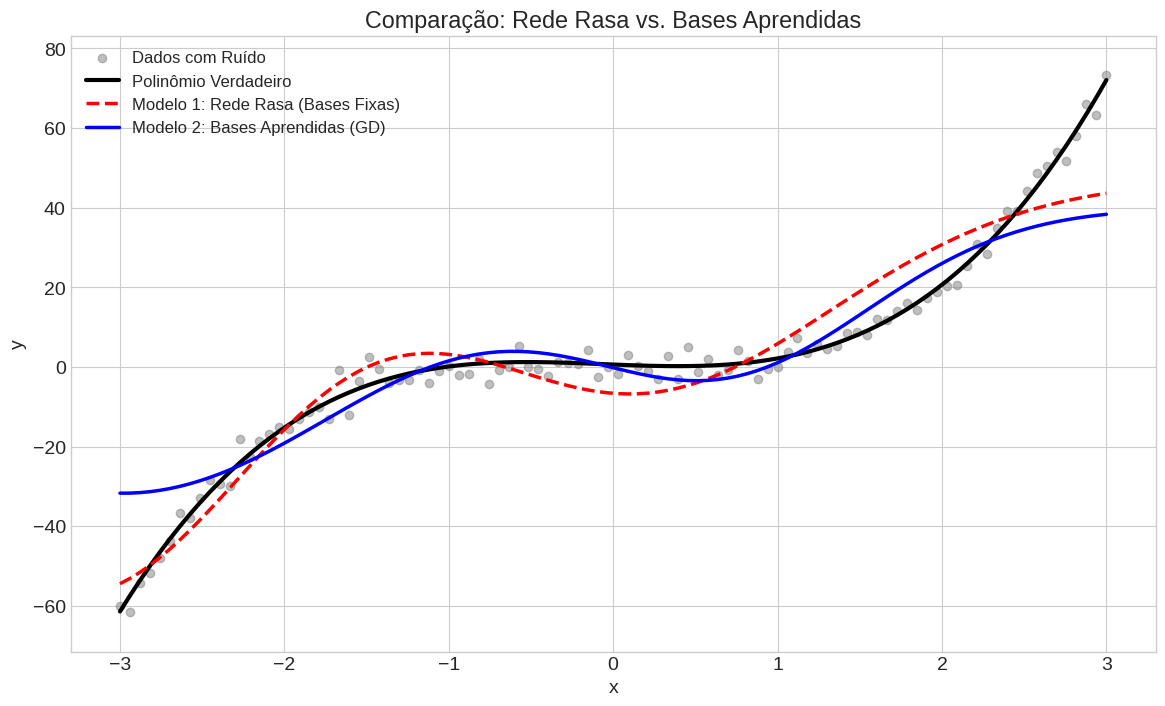

In [ ]:
plt.figure(figsize=(14, 8))

# Dados e função verdadeira
plt.scatter(x_data, y_data, label='Dados com Ruído', alpha=0.5, color='gray')
plt.plot(x_data, y_true, 'k-', linewidth=3, label='Polinômio Verdadeiro')

# Predição do Modelo 1 (Raso)
plt.plot(x_data, y_pred_shallow, 'r--', linewidth=2.5, label='Modelo 1: Rede Rasa (Bases Fixas)')

# Predição do Modelo 2 (Profundo)
plt.plot(x_data, y_pred_deep, 'b-', linewidth=2.5, label='Modelo 2: Bases Aprendidas (GD)')

# Detalhes do gráfico
plt.title('Comparação: Rede Rasa vs. Bases Aprendidas')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize=12)
plt.ylim(y_data.min() - 10, y_data.max() + 10)
plt.grid(True)

plt.savefig('comparacao_rbf.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# download as figuras geradas
from google.colab import files
files.download('dados_gerados.pdf')
files.download('comparacao_rbf.pdf')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>